Durante uma das aulas de inferência causal, o professor Rafael Stern nos apresentou o cenário de estimação de densidade condicional no contexto estimação do efeito causal utilizando o critério frontdoor.

O problema de quantificação da incerteza de uma previsão não me era novo, já tinha estudado um pouco sobre conformal predictions, onde se tenta estimar intervalos de confança para suas estimativas. Mas esse problema é naturalmente ainda mais complexo pois estamos tentando entender toda a distribuição condicional e não só alguns quantis.

Como o problema é super interessante, e a técnica apresentada (FlexCode) muito elegante, achei que fazia sentido escrever um pouco sobre por aqui.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd

plt.rcParams.update({'font.size': 8})

## Conditional Density Estimation in regression problems

When we attempt to model the relationship between a target variable $Y\in\mathbb{R}$ and one or more covariables $X$ we are usually trying to model a conditional-expectation type relationship. Matemáticamente, se a sua loss for o erro quadrático médio, estamos explicitamente tentando achar a função $\mathbb{E} \left( Y \,|\, X=x\right)$. Essa função naturalmente nos retorna uma previsão do valor médio de $Y$ quando as covariáveis valem $X=x$. While point estimates provide a quick and simple summary of expected outcomes, they often miss out on the rich complexity and uncertainty inherent in most real-world prediction tasks. Será que a variância ao redor desse valor médio é muito grande ou podemos confiar de que certamente o valor será próximo do valor previsto? 

Conditional Density Estimation (CDE) is focused on predicting an entire distribution of potential outcomes given some input data, rather than just a single point estimation. Matematicamente, estamos estimando a função densidade de probabilidade $f \left( y \,|\, X=x\right)$.

The comprehensive nature of CDE provides a rich understanding of the data's characteristics, and can be particularly beneficial in addressing two crucial aspects: catering to multi-modal outcomes and understanding model trustworthiness.

1. **Multi-modal outcomes:** Traditional regression or classification problems, which typically focus on single point predictions, often fail to capture the full complexity of real-world phenomena. This is especially evident when a single input can feasibly result in multiple valid outputs, a situation we refer to as multi-modality. For instance, consider a task like turning sketches into colored images. For any given sketch, there are multiple equally plausible colored images. By providing a full distribution of possible outcomes, CDE effectively captures these multiple modes, giving a richer and more realistic model of such scenarios.

2. **Model Trustworthiness:** Point estimation predictions do not provide any sense of their own reliability or uncertainty. In contrast, CDE provides a full distribution of potential outcomes, which inherently contains information about prediction confidence. The predicted distribution's width can serve as a measure of uncertainty or confidence. This feature can give users a more nuanced understanding of predictions, which is vital when making decisions based on those predictions. For example, in healthcare, a prediction about patient outcomes that comes with an understanding of confidence or uncertainty can lead to more informed and appropriate medical decisions.

$\oint$ _A área de conformal predictions tenta lidar com essa incerteza estimando intervalos de confiança $IC(X=x)$ ao redor das previsões do modelo de forma que $Y\,|\,X=x \in IC(X=x)$ com algum nível de confiança desejado. Interpretar o intervalo de confiança começa a responder algumas das perguntas possíveis que levantamos anteriormente. Entretanto ter os extremos do intervalo apenas (que naturalmente são tentativas de estimar quantis condicionais) não contam toda a história da incerteza associada à sua previsão, como, por exemplo, densidades multimodais._

## Example

Vamos construir um problema simples de exemplo para discutir o problema de CDE aplicando técnicas não-paramétricas. Imagine um processo gerador de dados da forma 

$$X\sim\textrm{Uniform}(0, 1),$$

$$Y | X \sim \sin(2\pi X) + \mathcal{N}(0, \sigma(X)),$$

com $\sigma(X) = 0.3 - 0.25 \sin(2\pi X)$.

Nesse exemplo $X$ é unidimensional simplesmente para facilitar a visualização, mas nossa discussão deveria ser agnóstica à dimensão de $X$.

In [2]:
def mean_function(X):
    return np.sin(2 * np.pi * X)

def deviation_function(X):
    return 0.3 + 0.25 * mean_function(X)

def generate_data_with_normal_noise(mean_generator, deviation_generator, size=5_000, random_state=None):
    def normal_noise_generator(X, deviation_generator, random_state=None):
        noise = np.random.RandomState(random_state).normal(loc=0, scale=deviation_generator(X))
        return noise
    
    rs = np.random.RandomState(random_state).randint(0, 2 * 32 - 1, size=2)
    X = np.random.RandomState(rs[0]).uniform(size=size)
    y_pred = mean_generator(X=X)
    noise = normal_noise_generator(X=X, deviation_generator=deviation_generator, random_state=rs[1])
    y_pred_noisy = y_pred + noise
    
    return X, y_pred_noisy

X, y = generate_data_with_normal_noise(mean_generator=mean_function, deviation_generator=deviation_function, random_state=42)

Naturamente, pela construção dos dados, a densidade condicional depende das covariáveis tanto na média quanto na variância.

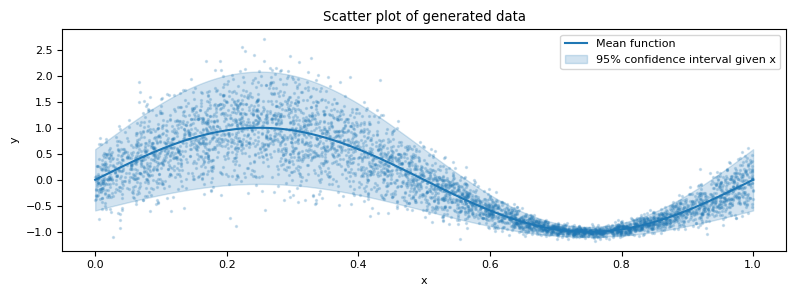

In [3]:
x_grid = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_grid, mean_function(x_grid), color="C0", label="Mean function")
ax.fill_between(
    x_grid,
    mean_function(x_grid) - 1.96 * deviation_function(x_grid),
    mean_function(x_grid) + 1.96 * deviation_function(x_grid),
    color="C0", alpha=0.2, label="95% confidence interval given x")
ax.scatter(X, y, s=2, color="C0", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Scatter plot of generated data")
ax.legend()
plt.tight_layout()

## Histograma

O problema de estimação de densidade pode parecer intimidador, mas, na prática, vemos que é bem familiar quando percebemos que o histograma (normalizado para ter integral 1) é justamente uma técnica com esse objetivo. Ao contar o número de exemplos em cada bin, estamos fazendo uma discretização da distribuição de forma que conseguimos estimar a probabilidade das regiões e obter uma estimação da densidade "com baixa resolução".

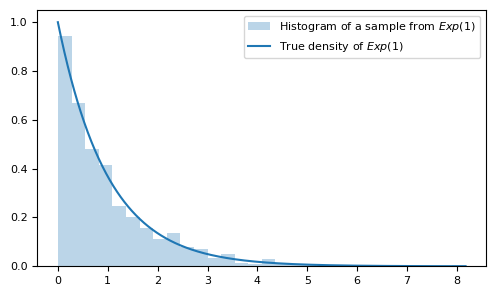

In [4]:
from scipy.stats import expon
hist_sample_example = np.random.RandomState(42).exponential(size=1000)
hist_linspace_example = np.linspace(0, max(hist_sample_example), 1000)
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(hist_sample_example, bins=30, density=True, color="C0", alpha=0.3, label="Histogram of a sample from $Exp(1)$")
ax.plot(hist_linspace_example, expon().pdf(hist_linspace_example), c="C0", label="True density of $Exp(1)$")
ax.legend()
plt.tight_layout()

Entretanto, utilizar todas as amostras nos dá uma estimativa da densidade de $Y$ sem nenhuma condicional em $X$.

Podemos condicionar essa estratégia em $X=x$ rapidamente, filtrando apenas pontos que estão próximos de $X=x$ quando criamos o histograma que vai representar aquela densidade condicional. A definição de pontos próximos pode variar. Podemos por exemplo usar uma estratégia do tipo `sklearn.neighbors.NearestNeighbors.radius_neighbors`, selecionando apenas os exemplos que estão em um raio de $\varepsilon$ ao redor do ponto $x$, ou selecionando de fato um número fixo de vizinhos mais proxímos com algo do tipo `sklearn.neighbors.NearestNeighbors.kneighbors`.

In [5]:
from scipy.stats import rv_histogram, norm
hist = np.histogram(y, bins=np.linspace(- 1.5, 3, 51))
hist_dist = rv_histogram(hist)

def plot_conditional_y_using_near_data(ax, x_value, X, y, c, eps=0.05):
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=c, label=f"real $f(y | x = {x_value})$")
    ax.hist(y[(X < x_value + eps) & (X > x_value - eps)], alpha=0.3, bins=y_grid, density=True, color=c, label=f"estimated $f(y | x = {x_value})$ using near data")

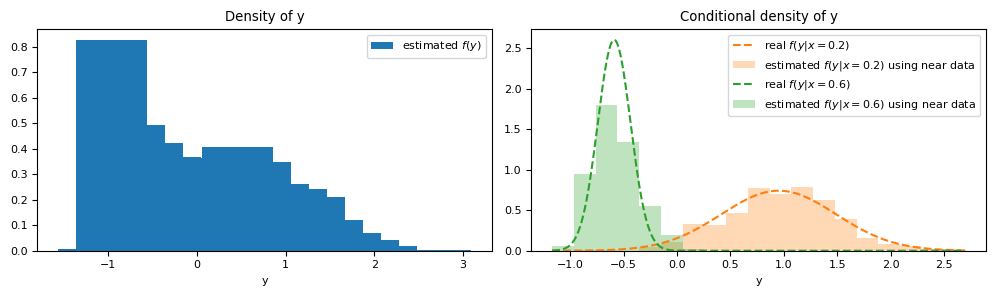

In [6]:
min_y, max_y = min(y), max(y)
y_grid = np.linspace(min_y, max_y, 20)
y_grid_refined = np.linspace(min_y, max_y, 1000)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].bar(y_grid, hist_dist.pdf(y_grid), label="estimated $f(y)$")
ax[0].set_title("Density of y")
ax[0].set_xlabel("y")
ax[0].legend()

plot_conditional_y_using_near_data(ax=ax[1], x_value=0.2, X=X, y=y, c="C1")
plot_conditional_y_using_near_data(ax=ax[1], x_value=0.6, X=X, y=y, c="C2")
ax[1].set_title("Conditional density of y")
ax[1].set_xlabel("y")
ax[1].legend()

plt.tight_layout()

## Kernel Density Estimation (KDE)

Histogramas são ótimos baselines, mas para distribuições mais complexas pode ser complexo saber qual o número de bins utilizar além de ficarmos com funções do tipo escada que podem não ser as mais agradáveis de se trabalhar.

De forma geral, o problema de estimação de densidade não-paramétrica costuma ser resolvido utilizando o KDE e faz sentido utilizar ele aqui também alinhado à alguma forma de transformar o problema em uma estimação condicional. O "long story short" do KDE é colocar bumps ao redor de pontos observados (com o formato de uma gaussiana, por exemplo) e somar esses bumps normalizando eles para ter uma estimativa da densidade.

$\oint$ _O tipo de bump (que é chamado de kernel) e a bandwidth (grossura) desses bumps são alguns hiperparâmetros que você pode ajustar utilizando validação cruzada com uma métrica estilo verossimilhança para ver se uma amostra de teste realmente é verossimil de ter sido amostrada da sua densidade estimada. Veja mais sobre isso em [[LINK](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)]._

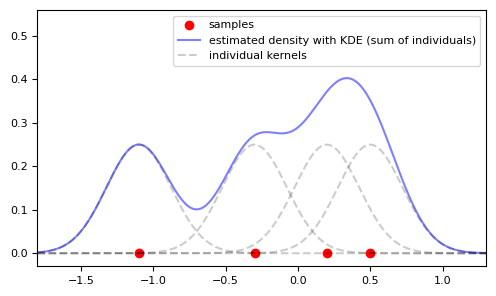

In [7]:
def gaussian_kernel(x, y):
    return np.exp(- (x - y)**2 / 0.1)

def kde(x, S):
    return sum(gaussian_kernel(x, s) for s in S)

S = [-1.1, -0.3, 0.2, 0.5]
grid_kde = np.linspace(-1.8, 1.3, 1000)

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(S, [0] * len(S), c='r')
ax.plot(grid_kde, kde(grid_kde, S)/len(S), c='b', alpha=0.5)
[ax.plot(grid_kde, gaussian_kernel(grid_kde, s) / len(S), '--', c='k', alpha=0.2) for s in S]
ax.set_ylim(-0.03, 0.56)
ax.set_xlim(-1.8,1.3)
ax.legend(["samples", "estimated density with KDE (sum of individuals)", "individual kernels"])
plt.tight_layout()

Para condicionar nosso KDE, podemos novamente usar novamente alguma busca de vizinhos.

Utilizando o `sklearn.neighbors.NearestNeighbors` e o `sklearn.neighbors.KernelDensity` (sem se preocupar muito com os hiperparâmetros desse modelo), conseguimos encontrar os vizinhos mais pertos de um determinado ponto, por exemplo $X=0.2$ e em seguida, com esse vizinhos, estimar a densidade.

In [8]:
from sklearn.neighbors import NearestNeighbors, KernelDensity

x_value = 0.2
knn = NearestNeighbors(n_neighbors=100).fit(X.reshape(-1, 1))
_, ind_x_value = knn.kneighbors([[x_value]])

kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(y[ind_x_value].reshape(-1, 1))

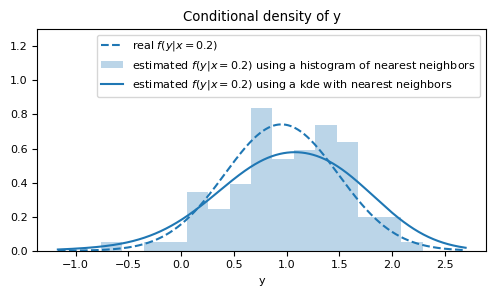

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color="C0", label=f"real $f(y | x = {x_value})$")
ax.hist(y[ind_x_value].ravel(), alpha=0.3, bins=y_grid, density=True, color="C0", label=f"estimated $f(y | x = {x_value})$ using a histogram of nearest neighbors")

ax.plot(y_grid_refined, np.exp(kde.score_samples(y_grid_refined.reshape(-1, 1))), color="C0", label=f"estimated $f(y | x = {x_value})$ using a kde with nearest neighbors")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.set_ylim(0, 1.3)
ax.legend()
plt.tight_layout()

Repare que esse método nos retorna uma estimativa muito mais suave que o histograma.

Podemos colocar essa lógica em uma classe com a API do scikit-learn fazendo com que o `.predict` faça essa lógica anterior para cada valor pedido (ou seja, primeiro buscar os vizinhos e em sequência utilizar um KDE para ter as estimações para cada exemplo).

In [10]:
from sklearn.base import BaseEstimator, clone

class ConditionalNearestNeighborsKDE(BaseEstimator):
    """TODO:Conditional Kernel Density Estimation using nearest neighbors.

    This class implements a Conditional Kernel Density Estimation by applying
    the Kernel Density Estimation algorithm after a nearest neighbors search.
    
    It allows the use of user-specified nearest neighbor and kernel density
    estimators or, if not provided, defaults will be used.

    Parameters
    ----------
    nn_estimator : NearestNeighbors instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.NearestNeighbors`
    class to use for finding nearest neighbors. If not specified, a
    `~sklearn.neighbors.NearestNeighbors` instance with `n_neighbors=100`
    will be used.

    kde_estimator : KernelDensity instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.KernelDensity`
    class to use for estimating the kernel density. If not specified,
    a `~sklearn.neighbors.KernelDensity` instance with `bandwidth="scott"`
    will be used.
    """
    def __init__(self, nn_estimator=None, kde_estimator=None):
        self.nn_estimator = nn_estimator
        self.kde_estimator = kde_estimator
        
    def fit(self, X, y=None):
        if self.nn_estimator is None:
            self.nn_estimator_ = NearestNeighbors(n_neighbors=100)
        else:
            self.nn_estimator_ = clone(self.nn_estimator)
        self.nn_estimator_.fit(X, y)
        self.y_train_ = y
        return self
    
    def predict(self, X):
        """Predict the conditional density estimation of new samples.

        The predicted density of the target for each sample in X is returned.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Vector to be estimated, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        kernel_density_list : list of len n_samples of KernelDensity instances
            Estimated conditional density estimations in the form of
            `~sklearn.neighbors.KernelDensity` instances.
        """
        _, ind_X = self.nn_estimator_.kneighbors(X)
        if self.kde_estimator is None:
            kernel_density_list = [KernelDensity(bandwidth="scott").fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        else:
            kernel_density_list = [clone(self.kde_estimator).fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        return kernel_density_list

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

ckde = ConditionalNearestNeighborsKDE().fit(X_train.reshape(-1, 1), y_train)
ckde_preds = ckde.predict(X_test.reshape(-1, 1))

## Avaliando a performance da nossa estimação de densidade condicional

Claramente as métricas usuais de regressão são dificeis de serem aplicadas aqui diretamente, necessitando de uma abordagem específica do problema que estamos tratando. Essa discussão é um pouco mais densa, mas importante para sabermos avaliar nossos estimadores.

$\oint$ _Algumas métricas de conformal prediction até podem ser utilizadas aqui como a "quantas vezes a target observada cai num intervalo de confiança", se você fizer intervalos de confiança a partir das densidades condicionais estimadas. Mas, novamente, métricas inerentes da naturezado problema são mais apropriadas._

Seja $f(y \,|\, X=x)$ a densidade de probabilidade condicional real do problema, e $\hat{f}(y \,|\, X=x)$ a densidade estimada. Queremos ver o quão próxima essas duas funções estão, com o detalhe de que não temos $f(y | x)$. Uma forma esperta de lidar com isso é calcular o erro médio quadrático em relação ao $X$:

$$ L(f, \hat{f}) = \mathbb{E}\left( \int \left( \hat{f}(y \,|\, X) - f(y \,|\, X) \right)^2 dy \right) = \int \int \left( \hat{f}(y \,|\, X=x) - f(y \,|\, X=x) \right)^2  dy \, f(x) \, dx.$$

$\oint$ _Essa métrica tem uma interpretação ligeiramente diferente do erro quadrático médio como risco empirico para nossas estimativas pontuais $h(x)$. Quando fazemos $\frac{1}{n} \sum_{i=1}^n \left( h(x_i) - y_i \right)$, estamos na verdade estimando_

$$\mathbb{E}\left( h(X) - Y \right) = \int \int \left( h(x) - y \right)^2 f(x,y) \, dx \, dy.$$

_Na métrica $L$ estamos fazendo a média apenas em relação à $X$ de forma que queremos que, fixado $X=x$, $\hat{f}(y \,|\, X=x)$ aproxime bem $f(y \,|\, X=x)$ para todos os valores possíveis de $y$ uniformemente em $\mathbb{R}$._

Fazendo a distributiva de $L$, ficamos com

$$ L(f, \hat{f}) = \int \int \left( \hat{f}(y \,|\, X=x) \right)^2 f(x) \, dy \, dx + \int \int -2\hat{f}(y \,|\, X=x) f(y, x) dx dy + C,$$

já que $f(x,y) = f(y \,|\, x) f(x)$ e definindo $C = \int \int \left( f(y \,|\, x) \right)^2 f(x) \, dy \, dx$. Como $C$ é uma constante que independe do método de estimação de $\hat{f}$, pode ser ignorada quando fazemos comparação entre modelos.

O primeiro termo pode ser escrito como como

$$ \int \left( \int \left( \hat{f}(y \,|\, X=x) \right)^2\, dy \right) f(x)  \, dx, $$

de forma que a integral interior pode ser calculada com algum método de integração numérica e a integral em x pode ser estimada com uma média empírica numa amostra $S=(x_i, y_i)_{i=1}^n$ de validação. Explicitamente, temos

$$ \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right). $$

Enquanto o segundo pode ser estimado diretamente como a média empírica

$$ \frac{-2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i) $$

também em $S$.

Nossas estimações nos permitem computar uma métrica de comparação de modelos dada por 

$$ L(f, \hat{f}, S) \approx \hat{L}(f, \hat{f}, S) = \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right) - \frac{2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i),$$

em que um modelo bom deveria ter ela a menor possível.

Podemos implementá-la de forma que receba as estimativas de densidade anteriormente calculadas e faça as operações necessárias (tanto a integração quanto o somatório). Para a integral estamos explicitamente pedindo um `y_grid` onde ela será estimada com o `sklearn.metrics.auc`.

In [12]:
from sklearn.metrics import auc, make_scorer
from joblib import Parallel, delayed

def squared_loss(y_true, cde_preds, y_grid, n_jobs=-1):
    """
    Average squared loss between the true and predicted conditional probabilities.

    This method can be used to assess the quality of the conditional probability
    density function fit.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        The true values of y for each sample.

    cde_preds : list of len n_samples of KernelDensity instances
        The predicted conditional densitys. Each instance should be a fitted
        KernelDensity instance.

    y_grid : array-like of shape (n_samples,)
        The grid of y values used for computing the area under the curve
        (AUC) for the squared PDF.

    n_jobs : int, optional
        The number of jobs to run in parallel. '-1' means using all processors.

    Returns
    -------
    average_squared_loss: float
        The average squared loss between the true and predicted conditional
        probability density functions. Note that it is always off by C.
    """
    def _compute_individual_loss(y_, cde_pred):
        # The score_samples and score methods returns stuff on log scale,
        # so we have to exp it.
        squared_auc = auc(y_grid, np.exp(cde_pred.score_samples(y_grid.reshape(-1, 1)))**2)
        expected_value = np.exp(cde_pred.score([[y_]]))
        return squared_auc - 2 * expected_value

    individual_squared_loss = Parallel(n_jobs=n_jobs)(
        delayed(_compute_individual_loss)(y_, cde_pred) for y_, cde_pred in zip(y_true, cde_preds)
    )

    average_squared_loss = sum(individual_squared_loss) / len(y_true)
    return average_squared_loss

Aplicando ela nos dados anteriores temos uma forma de quantificar o quão bem estamos realizando a tarefa de CDE.

In [13]:
squared_loss(y_test, ckde_preds, np.linspace(-5, 5, 1000))

-0.8507158015517423

Para efeito de comparação, podemos comparar com a estimação de densidade de $Y$ sem levar em conta a condicional, ou seja, podemos treinar o KDE em todos os dados de treino.

In [14]:
squared_loss(y_test, len(y_test)*[KernelDensity(bandwidth="scott").fit(y_train.reshape(-1, 1))], np.linspace(-5, 5, 1000))

-0.4007238630119935

Como o valor anterior é menor, concluímos que ele é uma estimação de densidade melhor, como esperado.

$\oint$ _Essa métrica é interessante para comparar modelos, mas pode ser difícil de interpretar do ponto de vista de negócios. Nesse caso, entendo que tentar transformar sua previsão de distribuição em uma previsão pontual para calcular alguma métrica tradicional como o `sklearn.metrics.mean_absolute_error` (ou mesmo métricas de conformal prediction) pode ser uma maneira de contornar o problema para ter uma interpretação mais palatável._

Tendo uma forma de comparar modelos é natural querer otimizar os hiperparâmetros com um `sklearn.model_selection.GridSearchCV` por exemplo. Como construimos o `ConditionalNearestNeighborsKDE` seguindo o padrão do sklearn, e a métrica de forma que recebe o output de um `.predict`, podemos simplesmente utilizar o `sklearn.model_selection.GridSearchCV` para otimizar por exemplo como queremos que o `sklearn.neighbors.NearestNeighbors` seja.

In [15]:
from functools import partial
from sklearn.model_selection import GridSearchCV

squared_loss_score = make_scorer(partial(squared_loss, y_grid=np.linspace(-5, 5, 1000)), greater_is_better=False)

param_grid = {
    "nn_estimator": [NearestNeighbors(n_neighbors=n_neighbors) for n_neighbors in [100, 500, 1000]],
}

gs = (
    GridSearchCV(
        ConditionalNearestNeighborsKDE(),
        param_grid=param_grid,
        scoring=squared_loss_score)
    .fit(X_train.reshape(-1, 1), y_train)
)

(
    pd.DataFrame(gs.cv_results_)
    .filter(["param_nn_estimator", "mean_score_time", "mean_test_score", "std_test_score"])
    .sort_values(by="mean_test_score", ascending=False)
    .reset_index(drop=True)
)

,param_nn_estimator,mean_score_time,mean_test_score,std_test_score
0,NearestNeighbors(n_neighbors=500),7.965259,0.866858,0.015677
1,NearestNeighbors(n_neighbors=100),2.659786,0.845465,0.016176
2,NearestNeighbors(n_neighbors=1000),13.719923,0.699505,0.013646


Nesse caso, obtemos um score melhor que o anterior usando valores quaisquer de vizinhos. Podemos ainda nos importar com os aspectos da estimação de kernel e isso poderia melhorar ainda o resultado.

In [16]:
squared_loss(y_test, gs.best_estimator_.predict(X_test.reshape(-1, 1)), np.linspace(-5, 5, 1000))

-0.9276598435770342

Essa estrutura foi apresentada por ser mais intuitiva, entretanto em dimensões mais altas ou em cenários de muitos dados, a busca de vizinhos tem alguns problemas. Primeiro, ela é computacionalmente custosa pois envolve comparações de distâncias. Segundo, ficamos facilmente a mercê de escalas distintas das variáveis, possivelmente com variáveis categoricas. Terceiro, podemos ter muitas variáveis pouco informativas em $X$ e, consequentemente, [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), com nossos vizinhos ficando cada vez mais distantes e sendo pouco representativos. Num problema real você talvez tenha centenas de covariáveis que você pode ter interesse em condicionar e milhões de exemplos, então essa estratégia pode não ser a mais indicada.


## LeafNeighbors

Existe uma forma de tentar driblar o problema da busca de vizinhos com dimensionalidade alta com variáveis irrelevantes e de escalas e tipos variados. Essa maneira é criar uma métrica de distância mais apropriada que seja robusta a isso.

Pela forma como o treinamento de árvores é feito, elas são naturalmente boas para lidar com esses problemas uma vez que: aprendem bem quais são as features importantes pelo processo de escolha do melhor split; não se preocupam com escala das variáveis uma vez que, no treinamento, olham apenas para ordenação.

Ao treinar um bagging de árvores, temos uma variabilidade de quebras do espaço de features que permite que usemos a coocorrência nas mesmas folhas como uma métrica de similaridade dos exemplos.

Portanto, se treinamos um modelo de bagging de árvores de regressão estilo `sklearn.ensemble.RandomForestRegressor` ou `sklearn.ensemble.ExtraTreesRegressor` para prever $Y$ a partir de $X$ estaremos naturalmente construindo árvores que fazem quebras em variáveis relevantes para o problema de previsão de $Y$ ao mesmo tempo que, contando as coocorrências de folhas nos diferentes modelos do bagging apenas, não nos preocupamos com as diferentes escalas pois consideramos similar todos que ocorrem na mesma folha.

Podemos implementar uma classe de busca de vizinhos que segue essa lógica, nos padrões do scikit-learn como:

In [17]:
from sklearn.neighbors._base import NeighborsBase

class LeafNeighbors(NeighborsBase):
    """Neighbors search using shared leaf nodes in a tree ensemble as a similarity measure.
    
    This class implements a supervised neighbor search using the leafs of an ensemble tree
    estimator as a measure of distance. Examples that occur simultaneously in several sheets
    are naturally close in variables relevant to the target.

    Parameters
    ----------
    tree_ensemble_estimator : ForestRegressor instance, default=None
        The ensemble tree estimator to use. If None, a `~sklearn.ensemble.RandomForestRegressor`
        with `max_depth=5` will be used.
    
    n_neighbors : int, default=5
        Number of neighbors to use in the neighbor-based learning method.
    
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the ensemble tree estimator. Pass an int for reproducible
        output across multiple function calls.
    """
    def __init__(self, tree_ensemble_estimator=None, n_neighbors=5, random_state=None):
        self.tree_ensemble_estimator = tree_ensemble_estimator
        self.n_neighbors = n_neighbors
        self.random_state = random_state
        
    def fit(self, X, y=None):
        if self.tree_ensemble_estimator is None:
            self.tree_ensemble_estimator = RandomForestRegressor(max_depth=5, random_state=self.random_state)
        else:
            self.tree_ensemble_estimator = clone(self.tree_ensemble_estimator)

        self.nn_estimator_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric="hamming")

        self.tree_ensemble_estimator.fit(X, y)
        leafs_X = self.tree_ensemble_estimator.apply(X)
        self.nn_estimator_.fit(leafs_X)
        return self
    
    def kneighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.kneighbors(leafs_X)
    
    def radius_neighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.radius_neighbors(leafs_X)

E utilizá-la dentro do nosso `ConditionalNearestNeighborsKDE`, definind o parâmetro `nn_estimator` com essa nossa nova busca.

In [18]:
crfkde = (
    ConditionalNearestNeighborsKDE(nn_estimator=LeafNeighbors(n_neighbors=100))
    .fit(X_train.reshape(-1, 1), y_train)
)
crfkde_preds = crfkde.predict(X_test.reshape(-1, 1))

squared_loss(y_test, crfkde_preds, np.linspace(-5, 5, 1000))

-0.8503601568396311

Nesse caso, a métrica ficou parecida com a encontrada no problema anterior com vizinhos já que a dimensão é baixa. Portanto, os vizinhos encontrados na reta praticamente coincidir com a busca de vizinhos próximos usual.

## FlexCode

O FlexCode vem para tentar contornar os problemas anteriores abordando o CDE de uma maneira completamente diferente: utilizando argumentos de álgebra linear para estimar a função densidade de probabilidade condicional a partir de uma base de funções.

O espaço das [funções quadrado integráveis](https://mathworld.wolfram.com/L2-Space.html) ($L^2(\mathbb{R})$) é um espaço vetorial com produto interno definido por $\left\langle g, h\right\rangle = \int_{\mathbb{R}} g(t)\, h(t) \, dt$.  E, assim como em espaços vetoriais de dimensão finita usuais, tem uma base (nesse caso, infinita) $\left\{ \phi_i \in L^2(\mathbb{R}) : i \in \mathbb{N}\right\}$ tal que qualquer $g \in L^2(\mathbb{R})$ pode ser escrito como uma combinação linear dos elementos da base, ou seja, $g(t) = \sum_{i=1}^\infty \beta_i \phi_i(t)$, $\forall t \in \mathbb{R}$. É possível forçar ainda que a nossa base seja ortonormal (de forma que $\left\langle \phi_i, \phi_j\right\rangle = \delta_{i,j}$ (ou seja, vale $1$ se $i = j$ e $0$ caso contrário).

$\oint$ _Para criar a intuição de que isso faz sentido, caso você nunca tenha visto, pense em como estamos num cenário similar às aplicações de [séries de Fourier](https://en.wikipedia.org/wiki/Fourier_series)._

Com qualquer base ortonormal $\left\{ \phi_i \right\}$ fixada, é possível escrever

$$f(y \,|\, X=x) = \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y),$$

em que estamos colocando a dependência de $X=x$ diretamente nos coeficientes da combinação linear.

Repare que, de $\left\{ \phi_i \right\}$ ser uma base ortornormal, então

$$
\begin{align}
    \mathbb{E}\left( \phi_j(Y) \,|\, X=x \right) &= \int_\mathbb{R} \phi_j(y) \,f(y \,|\, X=x) \,dy\\
    &= \int_\mathbb{R} \phi_j(y) \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \int_\mathbb{R} \phi_j(y) \, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \,\delta_{i,j} = \beta_j(x).
\end{align}
$$

Portanto, $\hat{\beta}_j(x)$ pode ser estimado com uma regressão utilizando $X$ para prever $\phi_j(Y)$.

O algoritmo [FlexCode](https://pypi.org/project/flexcode/) se propões a fazer justamente isso. Utilizando alguma base `basis_system` (hiperparâmetro do modelo), os coeficientes são estimados a partir dessas regressões de $\phi_j(Y)$. Como, naturalmente fazer a soma infinita é inviável, ela é trunca no valor `max_basis` $I$ (que pode ser achado via validação cruzada, encarado como hiperparâmetro). Temos portanto

$$ \hat{f}(y \,|\, X=x) = \sum_{i=1}^I \hat{\beta}_i(x) \, \phi(y).$$

## FlexCode no Python

Para utilizá-lo, definimos o modelo de regressão, parâmetros dele, além dos outros hiperparâmetros mencionados anteriormente.

In [19]:
from flexcode.regression_models import RandomForest
from flexcode import FlexCodeModel

flexcode_model = FlexCodeModel(RandomForest, basis_system="cosine", max_basis=31, regression_params={'max_depth': 5, 'n_estimators': 100})
flexcode_model.fit(X_train, y_train)

O output desse estimador, da maneira que está implementado, nos retorna o valor de $\hat{f}(y \,|\, X=x)$ num grid de valores de $y$.

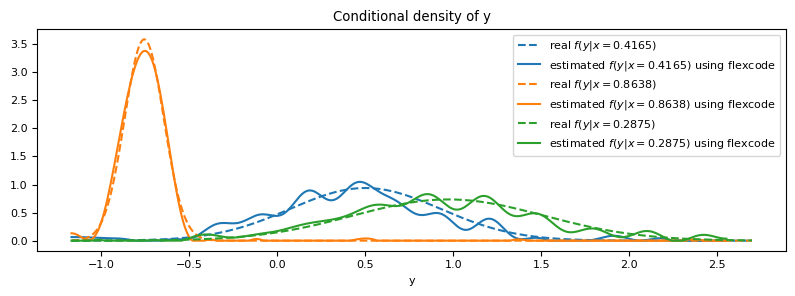

In [20]:
cdes, y_grid_flexcode = flexcode_model.predict(X_test, n_grid=400)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

fig, ax = plt.subplots(figsize=(8, 3))
for c, sample_index in enumerate(np.random.RandomState(0).choice(len(X_test), size=3)):
    x_value = np.round(X_test[sample_index], 4)
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=f"C{c}", label=f"real $f(y | x = {x_value})$")
    ax.plot(y_grid_flexcode, cdes[sample_index], color=f"C{c}", label=f"estimated $f(y | x = {x_value})$ using flexcode")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.legend()
plt.tight_layout()

Para avaliar o estimador, como construímos anteriormente nossa métrica de forma que ela recebe um objeto estilo o `sklearn.neighbors.KernelDensity`, em particular precisamos que ele tenha alguns métodos específicos que podemos implementar, adaptando o output do `flexcode.FlexCodeModel` para esse formato.

In [21]:
class FlexCode_return_to_DensityEstimator:
    def __init__(self, y_grid, pdf_values):
        self.y_grid = y_grid
        self.pdf_values = pdf_values
        self.density = rv_histogram((pdf_values, np.hstack([y_grid, [y_grid[-1] + y_grid[-1] - y_grid[-2]]])))

    def score_samples(self, X):
        return np.log(self.density.pdf(X))
    
    def score(self, X):
        return np.sum(self.score_samples(X))

In [22]:
density_estimation_preds_flexcode = [FlexCode_return_to_DensityEstimator(y_grid=y_grid_flexcode, pdf_values=cde) for cde in cdes]
squared_loss(y_test, density_estimation_preds_flexcode, np.linspace(-5, 5, 1000))

-1.6337318205659717

Nesse caso, obtemos uma métrica bem melhor que o KDE baseado em vizinhos mais próximos anterior.

## Aplicando num problema real

Vamos aplicar nossas diferentes técnicas em um problema de regressão real, sem uma construção artificial, para estudar como as nossas diferentes abordagens discutidas performam.

In [23]:
from sklearn.datasets import fetch_california_housing

X_california, y_california = fetch_california_housing(return_X_y=True)
X_california_train, X_california_test, y_california_train, y_california_test = train_test_split(
    X_california, y_california, test_size=0.33, random_state=42)
print(f"X dimension: {X_california.shape[1]}")

X dimension: 8


In [24]:
ckde_california = ConditionalNearestNeighborsKDE().fit(X_california_train, y_california_train)
ckde_california_preds = ckde_california.predict(X_california_test)

squared_loss(y_california_test, ckde_california_preds, np.linspace(0, 6, 1000))

CPU times: total: 8.58 s
Wall time: 24.6 s


-0.2948159711962537

In [25]:
crfkde_california = ConditionalNearestNeighborsKDE(nn_estimator=LeafNeighbors(n_neighbors=100)).fit(X_california_train, y_california_train)
crfkde_california_preds = crfkde_california.predict(X_california_test)

squared_loss(y_california_test, crfkde_california_preds, np.linspace(0, 6, 1000))

CPU times: total: 24.2 s
Wall time: 1min 20s


-0.5759885602904633

In [26]:
model_california = FlexCodeModel(RandomForest, max_basis=31, regression_params={'max_depth': 10, 'n_estimators': 100})
model_california.fit(X_california_train, y_california_train)

cdes_california, y_grid_california = model_california.predict(X_california_test, n_grid=400)
y_grid_california = y_grid_california.reshape(-1)
density_estimation_preds_flexcode_california = [FlexCode_return_to_DensityEstimator(y_grid=y_grid_california, pdf_values=cde) for cde in cdes_california]

squared_loss(y_california_test, density_estimation_preds_flexcode_california, np.linspace(0, 6, 1000))

CPU times: total: 10.3 s
Wall time: 2min 38s


-1.2742897289786725

C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_55188_c92f376be7374b95ad7d0e5734811a7b_4fe214cd56fa4cacae16f7bdc4534496
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_55188_a75708cea61d4e1cb153fd08894b4985_2c3d4bfe688a4ca797d9fadda72b552b
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_55188_c92f376be7374b95ad7d0e5734811a7b_e0773500341540b7a0043377ad945d90
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppD

Vemos que, de fato, a busca de vizinhos com o `LeafNeighbors` superou a busca de vizinhas usual no nosso método de `ConditionalNearestNeighborsKDE`, entretanto o `flexcode.FlexCodeModel` tem resultados superiores aos dois.

___

## Considerações finais

Olhar para o problema de regressão além da estimativa pontual é desafiador, mas te dá informações mais ricas que podem ajudar no seu processo de decisão. Apesar de importante, é uma área pouco ativa em termos de comunidade, mas que prevejo ganhando mais atenção conforme as pessoas conheçam. É natural que, atualmente, as bibliotecas que tentam abordar esse problema tenham alguns bugs que vão sendo resolvidos ao longo do tempo. É importante, portanto, utilizar com esse cuidado e reportando qualquer comportamento que pareça estranho.

$\oint$ _Me importei em mencionar o método baseado em vizinhos das árvores porque é possível adaptar o treinamento da árvore de uma maneira específica para o problema de CDE. De forma usual num problema de regressão, a nossa árvore vai estar tentando otimizar alguma métrica estilo `sklearn.metrics.mean_squared_error` na hora de construir seus splits. Entretanto, é possível tentar otimizar diretamente nos splits alguma métrica de CDE como a `squared_error` que discutimos anteriormente. É isso que o método [RFCDE (Random Forests for Conditional Density Estimation)](https://github.com/lee-group-cmu/RFCDE) se propõe a fazer. A implementação em Python foi feita pelos mesmos contribuidores que adaptaram o código de FlexCode do [R](https://github.com/rizbicki/FlexCoDE) para o [Python](https://github.com/lee-group-cmu/FlexCode)._

## TO DO:

- Traduzir.

- Garantir que tá no formato com links pros estimadores do sklearn. Rodar um flake8. Docstring tbm por exemplo.


Referencias:

outras que eu coloquei la em cima.

https://gdmarmerola.github.io/forest-embeddings/

https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Converting-high-dimensional-regression-to-high-dimensional-conditional-density-estimation/10.1214/17-EJS1302.full

https://arxiv.org/abs/1804.05753

https://jmlr.csail.mit.edu/papers/volume7/meinshausen06a/meinshausen06a.pdf